# RUL Prediction with LSTM
a. Xs' only  
b. Xs' and W  
c. Xs' and W and $\theta$

1. Load flight effects model and validate performance
2. set up hyperparameter tuning for RUL prediction network (LSTM)
3. Evaluate different lookback windows or implement adaptive window

In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

base_dir = os.path.dirname(os.getcwd())
print(base_dir)
sys.path.insert(1, base_dir)
from package.api import DB as api
import package.utils as utils
import package.tuning as tuning
utils.check_gpu()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers, metrics
#import tensorflow_addons as tfa

import keras_tuner as kt

from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)


%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\Marcos Quinones\phm2021_data_challenge


C:\Users\lab\envs\tfgpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2.8.0
[INFO] GPU?: <True> [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
expanding memory growth


## 0. Connect to db and load the data

In [2]:
# THESE ARE YOUR CREDENTIALS IN PLAIN TEXT!
params = {'datasource.username': 'macslab', # the username of the logged in user
            'datasource.password': 'Ch0colate!', 
            'datasource.database': 'ncmapss_db', # <- NO CHANGE 
            'datasource.url': '10.2.219.98', # <- or your database installation location
            'datasource.port': '5432'} # <- most likely don't change
#print(params)
db, cur =  api.connect(params)
db.set_session(autocommit=True)
del(params)

[INFO] connecting to db.
[INFO] connected.


In [3]:
units = api._get_units(db=db)
units.head()

C:\Users\lab\envs\tfgpu\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,serial_number,age,eol,rul,group_id,Fc,unit,dataset
0,1,xhJzs6e3,0.0,100.0,100.0,1,1,1,DS01-005
1,2,a2wH8lJP,0.0,75.0,75.0,1,3,2,DS01-005
2,3,zwaWwxPl,0.0,100.0,100.0,1,2,3,DS01-005
3,4,ByMDLFeB,0.0,95.0,95.0,1,1,4,DS01-005
4,5,rcedq8Jy,0.0,89.0,89.0,1,3,5,DS01-005


In [16]:
tables = ['summary_tb', 'telemetry_tb']
downsample=20
df = api._get_data(db=db,
                   units=pd.unique(units.id),
                   tables=tables,
                   downsample=downsample).astype(np.float32)
utils.add_time_column(units=pd.unique(units.id), df=df)
utils.add_rul_column(units=pd.unique(units.id), df=df)

C:\Users\lab\envs\tfgpu\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\lab\envs\tfgpu\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## 1. Make Xs_prime and y 

In [18]:
X_cols = ['Mach', 'alt', 'TRA', 'T2', 'time']## disregard comments #, 'Fc'] # will also have Fc_1, Fc_2, Fc_3
y_cols = ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50']
a_cols = ['cycle', 'hs', 'Fc', 'asset_id']

model = keras.models.load_model('models/ncmapss/flight_effects.h5')
yscaler = joblib.load('models/ncmapss/flight_effects_yscaler.pkl')
xscaler = joblib.load('models/ncmapss/flight_effects_xscaler.pkl')

#df[X_cols] = xscaler.transform(df[X_cols])
trace = yscaler.transform(df[y_cols])
pred = model.predict(xscaler.transform(df[X_cols]))
res = trace - pred
dfx = pd.DataFrame(data=res, columns=y_cols)
df_x = pd.DataFrame(data=xscaler.transform(df[X_cols]), columns=X_cols)
dfx = pd.concat([dfx, df_x, df[a_cols]], axis=1)
dfx['rul'] = df['rul'].values
dfx.time = dfx.time + (dfx.cycle -1)
dfx0 = dfx[dfx.hs == 0]

In [44]:
dfx0.head()

,Wf,Nf,Nc,T24,T30,T48,T50,P15,P2,P21,...,Mach,alt,TRA,T2,time,cycle,hs,Fc,asset_id,rul
7836,-0.000471,0.001766,-0.000791,0.001722,-0.000761,-0.000426,-0.000987,0.000383,0.000090,0.000415,...,0.480052,0.004090,0.756065,0.954463,36.000000,37.0,0.0,1.0,1.0,64.0
7837,0.001433,0.000124,-0.001088,0.000391,-0.000735,0.001195,0.002385,0.000502,0.000942,0.000445,...,0.487148,0.010459,0.721024,0.950999,36.004505,37.0,0.0,1.0,1.0,63.995495
7838,0.001703,-0.000359,-0.000892,0.000580,-0.000830,0.001486,0.002831,0.000540,0.000486,0.000553,...,0.486223,0.018576,0.726415,0.941302,36.009009,37.0,0.0,1.0,1.0,63.990991
7839,0.001122,-0.000248,-0.000901,0.000835,-0.001088,0.001105,0.002059,0.000493,0.000350,0.000628,...,0.498471,0.023665,0.730458,0.942108,36.013514,37.0,0.0,1.0,1.0,63.986486
7840,0.000898,-0.000326,-0.001055,0.000787,-0.001283,0.000973,0.001869,0.000332,0.000318,0.000584,...,0.505742,0.027411,0.730458,0.941822,36.018018,37.0,0.0,1.0,1.0,63.981982


In [43]:
dfx0 = dfx[dfx.hs == 0]

## 2. split sets and view feature distributions

In [27]:
dfx[dfx.asset_id == asset_id][y_cols].values[:,5]

array([-1.7404556e-04, -1.9633770e-04, -8.0764294e-05, ...,
        3.9302647e-02,  3.9339095e-02,  3.9398402e-02], dtype=float32)

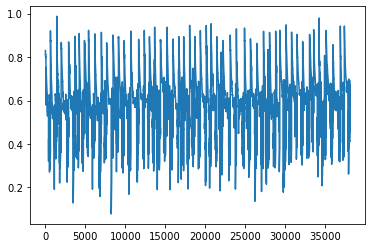

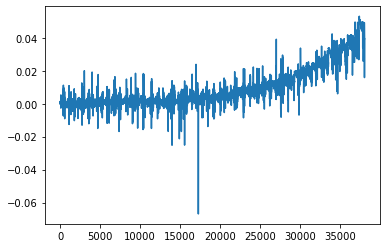

In [35]:
#########################################################

y_full = df[df.asset_id == asset_id][y_cols]
X_full = df[df.asset_id == asset_id][X_cols]

trace = yscaler.transform(y_full)[:,idx]

plt.plot(trace)
plt.show()

pred = model.predict(xscaler.transform(X_full))[:,idx]
res = trace - pred

plt.plot(res)
plt.show()

In [45]:
train_df, train_y, val_df, val_y, test_df, test_y = utils.train_test_split(df=dfx0, units=list(pd.unique(units.id)), y_labels=['rul'], t_labels=a_cols + y_cols + X_cols, train_pct = .80, val_pct=.10, test_pct=.10, verbose=True)

90
72
9
9
train, val, test set counts: 72, 9, 9
90 90
train units: [82, 68, 71, 47, 46, 4, 84, 67, 15, 78, 20, 89, 58, 26, 74, 7, 65, 10, 32, 70, 81, 34, 61, 39, 60, 52, 49, 27, 23, 63, 24, 73, 12, 83, 56, 37, 85, 72, 18, 30, 1, 21, 86, 57, 50, 77, 38, 55, 79, 87, 51, 25, 48, 22, 2, 13, 5, 19, 33, 62, 14, 17, 54, 66, 53, 6, 88, 36, 45, 31, 3, 16]
val units: [90, 8, 64, 40, 76, 80, 29, 43, 35]
test units: [28, 9, 41, 59, 75, 69, 42, 11, 44]


### verify correct data!!!

T48
5 82


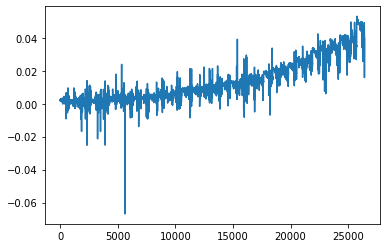

In [46]:
idx = 5#np.random.randint(len(y_cols))
asset_id = 82#np.random.randint(max(units.id))
print(y_cols[idx])
print(idx, asset_id)

plt.plot(train_df[train_df.asset_id == asset_id][y_cols].values[:,5])
plt.show()
         

In [47]:
train_y = pd.DataFrame(data=train_y, columns=['rul'])
val_y = pd.DataFrame(data=val_y, columns=['rul'])
test_y = pd.DataFrame(data=test_y, columns=['rul'])

In [48]:
train_pop = pd.concat([train_df.pop(x) for x in ['asset_id', 'cycle', 'hs', 'Fc']], axis=1)
val_pop = pd.concat([val_df.pop(x) for x in ['asset_id', 'cycle', 'hs', 'Fc']], axis=1)
test_pop = pd.concat([test_df.pop(x) for x in ['asset_id', 'cycle', 'hs', 'Fc']], axis=1)

In [49]:
train_df.to_csv('train_df.csv')
train_pop.to_csv('train_pop.csv')
train_y.to_csv('train_y.csv')

val_df.to_csv('val_df.csv')
val_pop.to_csv('val_pop.csv')
val_y.to_csv('val_y.csv')

test_df.to_csv('test_df.csv')
test_pop.to_csv('test_pop.csv')
test_y.to_csv('test_y.csv')

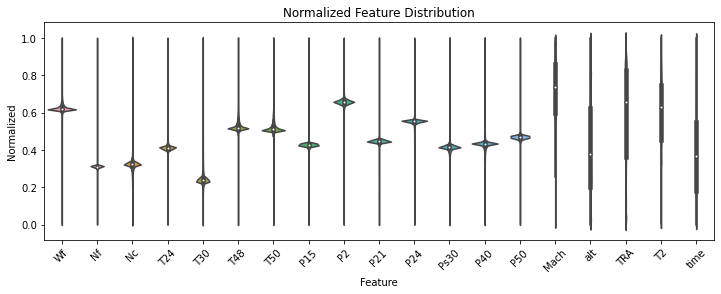

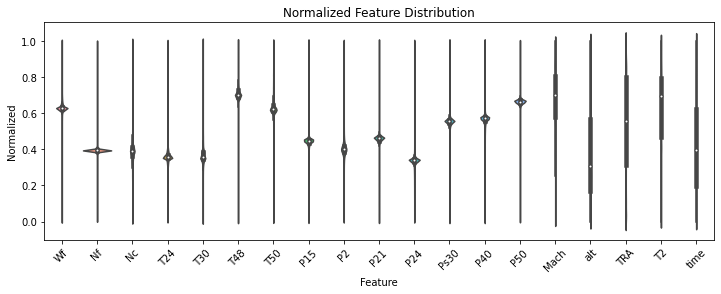

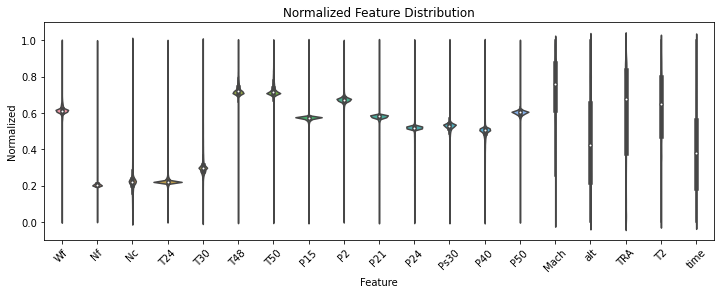

In [42]:
utils.plot_feature_distributions(df=train_df, feature_range=(0,1), figsize=(12,4))
utils.plot_feature_distributions(df=val_df, feature_range=(0,1), figsize=(12,4))
utils.plot_feature_distributions(df=test_df, feature_range=(0,1), figsize=(12,4))

### plot feature importances

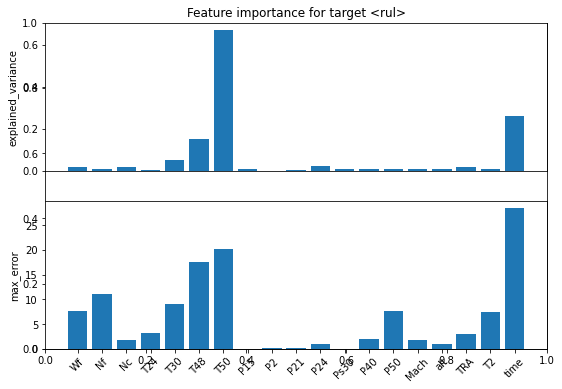

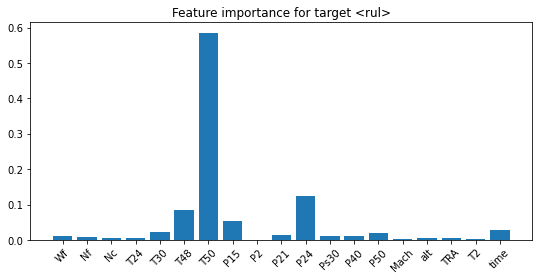

In [50]:
from xgboost import XGBRegressor
importance_model = XGBRegressor()
importance_model.fit(train_df.values, train_y)

scoring = ['explained_variance',
           'max_error']#,
           #'neg_mean_absolute_error',
           #'neg_root_mean_squared_error',
           #'r2']

utils.plot_feature_importances(model=importance_model,
                               features=train_df.values,
                               feature_labels=y_cols + X_cols,
                               target=train_y,
                               target_label='rul',
                               scoring=scoring)

utils.plot_feature_importance(features=train_df.values,
                              feature_labels=y_cols + X_cols,
                              target=train_y,
                              target_label='rul',
                              figsize=(9,4))

In [52]:
important_features = list(train_df.columns) #['Wf','Nc', 'T24', 'T48', 'T50', 'P2', 'Ps30', 'P40']
important_features = ['Wf','Nf', 'T30', 'T48', 'T50', 'P15', 'P24', 'P40', 'P50','TRA', 'T2', 'time']
important_features

['Wf',
 'Nf',
 'T30',
 'T48',
 'T50',
 'P15',
 'P24',
 'P40',
 'P50',
 'TRA',
 'T2',
 'time']

## 2. temporalize the data

In [53]:
#important_features = list(train_df.columns)

lookback = 100
horizon = 1
n_out = 1
n_features = train_df[important_features].shape[1]

X_train, y_train = utils.temporalize_data(train_df[important_features].values, train_y.values, lookback, horizon, n_features, n_out)
#train_pop_temp, y_pop = utils.temporalize_data(train_pop.values, train_y, lookback, horizon, len(train_pop.columns), n_out)

# X_val, y_val = utils.temporalize_data(val_df.values, val_y, lookback, horizon, n_features, n_out)
# val_pop_temp, y_pop = utils.temporalize_data(val_pop.values, val_y, lookback, horizon, n_features, n_out)

# X_test, y_test = utils.temporalize_data(test_df.values, test_y, lookback, horizon, n_features, n_out)
# test_pop_temp, y_pop = utils.temporalize_data(test_pop.values, test_y, lookback, horizon, n_features, n_out)

## Parameter search

In [56]:

input_shape = (lookback, n_features)
my_tuning = tuning.Tuning(input_shape, n_out)
bayesian_tuning = my_tuning.bayesian_search(objective='root_mean_squared_error',
                                            mode='min',
                                            max_trials=128,
                                            alpha=.0001,
                                            beta=2.6,
                                            epochs=3,
                                            executions_per_trial=1,
                                            hypermodel=my_tuning.create_lstm_hypermodel,
                                            directory='logs/ncmapss2/bayesiansearch',
                                            project_name='lstm',
                                            logger=TensorBoardLogger(
                                                metrics=['root_mean_squared_error'],
                                                         logdir='logs/ncmapss2/hparams'
                                            ),
                                            X=X_train,
                                            y=y_train)

bayesian_tuning_params = bayesian_tuning.get_best_hyperparameters(num_trials=1)[0]
bayesian_tuning_model = bayesian_tuning.get_best_models()[0]
print(bayesian_tuning_params.values)
bayesian_tuning_model.summary()

save_dir = 'models/ncmapss/'
name = 'rul_best_model'

bayesian_tuning_model.save(save_dir + name + '.h5')
bayesian_tuning_model.save(save_dir + name)


Trial 12 Complete [00h 33m 25s]
root_mean_squared_error: 6.850937366485596

Best root_mean_squared_error So Far: 6.214498519897461
Total elapsed time: 05h 08m 49s


TypeError: 'float' object is not subscriptable

In [ ]:
# Xs_prime = []
# idx = np.random.randint(len(y_cols))
# polys = []

# df[X_cols] = xscaler.transform(df[X_cols])
# pred = model.predict(df[X_cols])

# for asset_id in pd.unique(df.asset_id):
#     X_full = df[df.asset_id == asset_id][X_cols]
#     pred = model.predict(X_full)
#     # pred = model.predict(xscaler.transform(X_full))
#     Xs_prime.append(pred)
    
#    y_full = df[df.asset_id == asset_id][y_cols]
#    trace = yscaler.transform(y_full)
#     res = trace - pred

#     x = np.arange(0, len(res[:,0]))
#     x = x[0:len(x):10]
#     for i in range(0, len(y_cols)):
#         y = res[:,i]
#         y = y[0:len(y):10]
#         reg = np.poly1d(np.polyfit(x, y, 6))
#         polys.append(reg)

#     fig = plt.figure(figsize=(12,12))
#     filtered = np.zeros(res.shape)
#     x = np.arange(0, len(res[:,0]))
#     for j in range(len(y_cols)):
#         y = res[:,j]
#         p = polys[j]

#         diff = np.zeros((len(y),))
#         for i in range(len(y)):
#             predp = p(y[i])
#             diff[i] = y[i] - predp

#         mean = np.mean(diff)
#         std = np.std(diff)

#         filt = np.zeros((len(y),))
#         for i in range(len(res)):
#             if np.abs(np.abs(y[i]) - np.abs(p(x[i]))) > np.abs(mean)+3*std:
#                 filt[i] = p(x[i])
#             else:
#                 filt[i] = y[i]

#         filtered[:,j] = filt
#         utils.plot_trace_samples(fig, y, filt, p, j)
#     plt.show()
#     Xs_prime.append(pred)

In [ ]:
# import Queue
# from threading import Thread

# units = api._get_units(db=db)
# tables = ['summary_tb', 'telemetry_tb']

# def func(units, tables, downsample):
#     return str(units) + str(tables) + str(downsample)
# def delegate():
#     return func('units', ' tables', 20)
# units = api._get_units(db=db)
# data_frames = []
# for i in range(int(len(units)/10)):
    
    
    # df = api._get_data(db=db,
    #                    units=units,
    #                    tables=tables,
    #                    downsample=20).astype(np.float32)
    
    
# train_df = pd.read_csv('train_df.csv', index_col=0)
# train_pop = pd.read_csv('train_pop.csv', index_col=0)
# train_y = pd.read_csv('train_y.csv', index_col=0)